# Instalando Dependencias Necesarias

In [2]:
!py -m pip install --upgrade pip
!py -m pip install pandas numpy
!py -m pip install openpyxl
!py -m pip install numpy scipy matplotlib
!py -m pip install scikit-learn
!py -m pip install plotly

   ---------------------------------------- 0.0/19.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/19.0 MB ? eta -:--:--
    --------------------------------------- 0.3/19.0 MB ? eta -:--:--
   -- ------------------------------------- 1.3/19.0 MB 3.9 MB/s eta 0:00:05
   ----------- ---------------------------- 5.5/19.0 MB 9.9 MB/s eta 0:00:02
   ---------------------------- ----------- 13.4/19.0 MB 17.8 MB/s eta 0:00:01
   ---------------------------------------- 19.0/19.0 MB 21.8 MB/s eta 0:00:00


# Punto 1.2 tomando de base los datos desarrollados en el archivo Taller1.xlsx

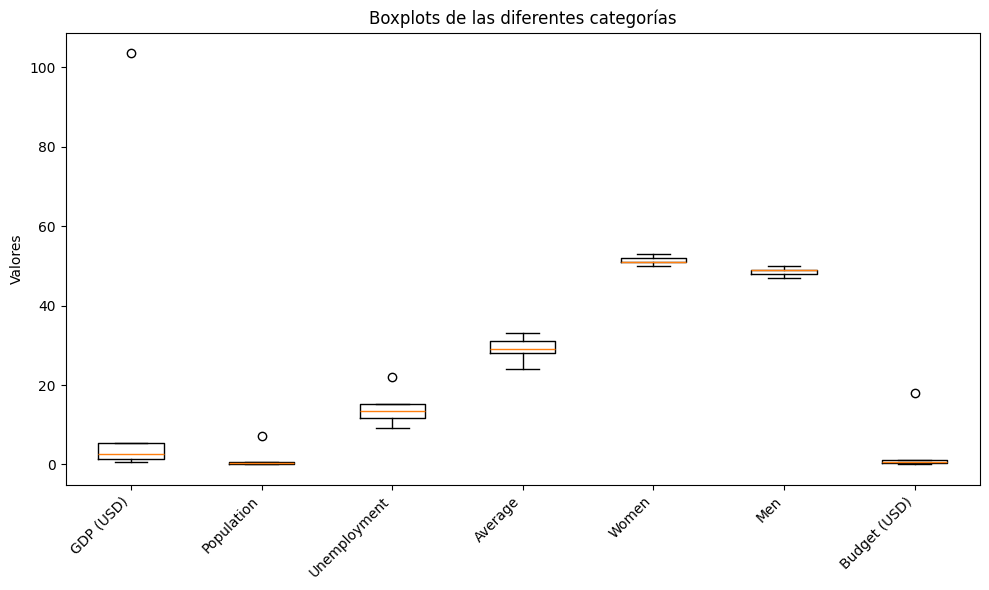

In [3]:
import matplotlib.pyplot as plt

# Datos de la segunda
data = {
    'GDP (USD)': [0.6, 1.275, 2.65, 5.375, 103.5],
    'Population': [0.01, 0.145, 0.39, 0.5425, 7.18],
    'Unemployment': [9.2, 11.575, 13.45, 15.325, 22],
    'Average': [24, 28, 29, 31, 33],
    'Women': [50, 51, 51, 52, 53],
    'Men': [47, 48, 49, 49, 50],
    'Budget (USD)': [0.05, 0.275, 0.6, 1.225, 18]
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(data.values())
ax.set_xticklabels(data.keys(), rotation=45, ha='right')

# Título y etiquetas
ax.set_title('Boxplots de las diferentes categorías')
ax.set_ylabel('Valores')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Graficando Individualmente

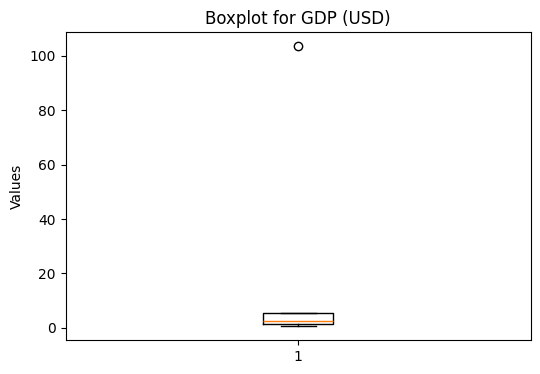

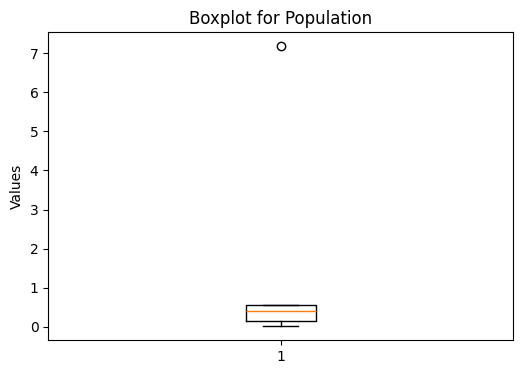

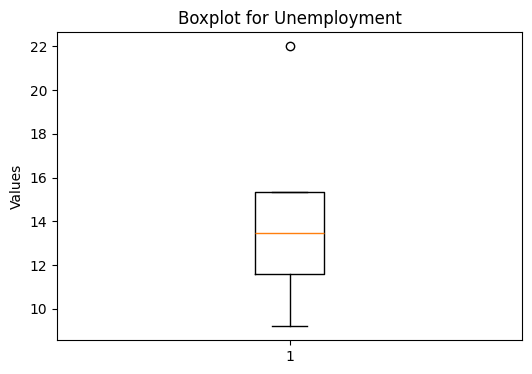

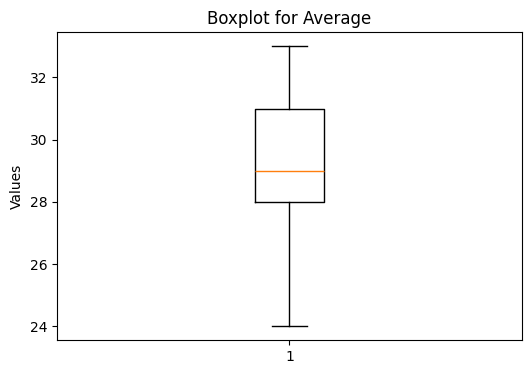

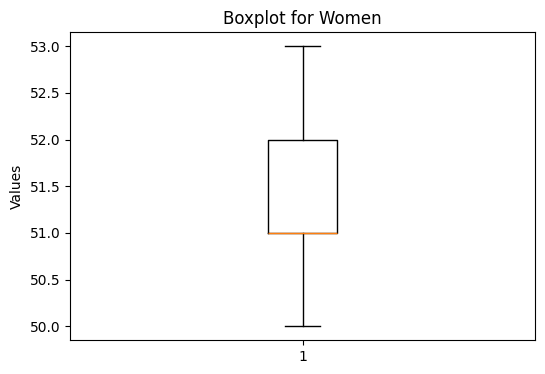

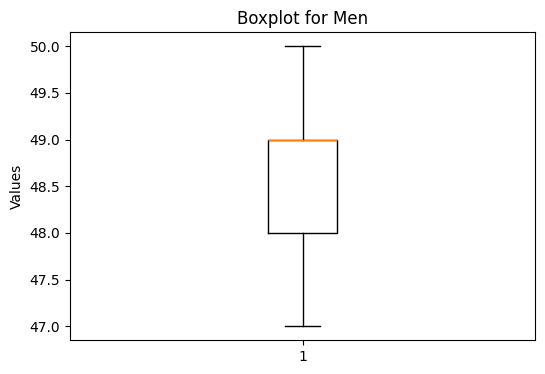

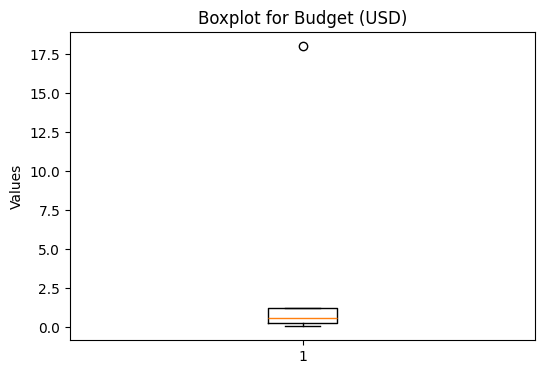

In [26]:
for category, values in data.items():
    plt.figure(figsize=(6, 4))
    plt.boxplot(values)
    
    # Formatear titulo con la etiquetas
    plt.title(f'Boxplot for {category}')
    plt.ylabel('Values')
    plt.show()

## Punto 1.6 Resultado de K Means para K=6 con los datos de entrenamiento

In [27]:
import pandas as pd
import numpy as np
import random
import math
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Paso 1: Leer los datos desde un archivo CSV
df = pd.read_csv('data/kmeans-cities/train.csv')

# Columnas numéricas que se usarán para K-Means
data = df[['GDP (USD Billion)', 'Population (Millions)', 'Unemployment Rate (%)', 'Average Age', 'Women (%)', 'Men (%)', 'Budget (USD Billion)']].values

# Paso 2: Inicializar centroides aleatoriamente (k=6 para 6 clusters)
def initializeCentroids(data, k):
    return random.sample(data.tolist(), k)

# Paso 3: Calcular la distancia euclidiana entre dos puntos
def euclideanDistance(point1, point2):
    return math.sqrt(sum([(p1 - p2) ** 2 for p1, p2 in zip(point1, point2)]))

# Paso 4: Asignar cada punto al centroide más cercano
def assignClusters(data, centroids):
    clusters = []
    distances = []  # Guardar las distancias para cada punto a cada centroide
    for point in data:
        distToCentroids = [euclideanDistance(point, centroid) for centroid in centroids]
        distances.append(distToCentroids)
        clusters.append(distToCentroids.index(min(distToCentroids)))  # El índice del centroide más cercano
    return clusters, distances

# Paso 5: Recalcular centroides
def updateCentroids(data, clusters, k):
    newCentroids = []
    for i in range(k):
        clusterPoints = [data[j] for j in range(len(data)) if clusters[j] == i]
        if clusterPoints:
            newCentroid = np.mean(clusterPoints, axis=0)
            newCentroids.append(newCentroid)
        else:
            newCentroids.append(random.choice(data))  # Si no hay puntos en un cluster, reasigna aleatoriamente
    return newCentroids

# Paso 6: Guardar resultados en una misma hoja Excel usando solo openpyxl
def saveResultsToExcel(df, centroids, distances, clusters, iteration, fileName='kmeans_resultado_final.xlsx'):
    # Guardar distancias en el DataFrame
    for i, centroid in enumerate(centroids):
        df[f'dis_C{i}'] = [dist[i] for dist in distances]
    
    # Guardar los clusters
    df['Cluster'] = clusters

    # Crear un DataFrame para los centroides
    centroidDf = pd.DataFrame(centroids, columns=df.columns[1:8])

    # Cargar o crear el archivo Excel
    try:
        book = load_workbook(fileName)  # Intenta cargar el archivo si ya existe
    except FileNotFoundError:
        book = Workbook()  # Si no existe, crea un nuevo libro de trabajo
        ws = book.active
        ws.title = "Resultados KMeans"
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        book = Workbook()
        ws = book.active
        ws.title = "Resultados KMeans"

    ws = book.active

    # Insertar el título de la iteración
    ws.append([f"Iteración {iteration}"])
    ws.append([])

    # Agregar la tabla de datos
    for row in dataframe_to_rows(df, index=False, header=True):
        ws.append(row)

    # Insertar un título para la tabla de centroides
    ws.append([f"Centroides Iteración {iteration}"])
    ws.append([])

    # Agregar la tabla de centroides
    for row in dataframe_to_rows(centroidDf, index=False, header=True):
        ws.append(row)
    
    # Guardar cambios
    book.save(fileName)
    book.close()

# Paso 7: Implementar el algoritmo K-Means
def kmeansWithExcel(data, df, k, maxIterations=100, fileName='kmeans_resultado_final.xlsx'):
    centroids = initializeCentroids(data, k)
    
    for iteration in range(maxIterations):
        clusters, distances = assignClusters(data, centroids)
        newCentroids = updateCentroids(data, clusters, k)
        
        # Guardar los resultados en un archivo Excel (una sola hoja)
        saveResultsToExcel(df.copy(), centroids, distances, clusters, iteration, fileName)
        
        # Verificar si los centroides cambiaron
        if np.allclose(centroids, newCentroids):
            print(f"Convergencia alcanzada en la iteración {iteration}")

            # Guardar los centroides finales en un archivo CSV
            centroid_df = pd.DataFrame(newCentroids, columns=df.columns[1:8])
            centroid_df.to_csv('centroides_finales.csv', index=False)
            print("Centroides finales guardados en 'centroides_finales.csv'.")
            break
        
        centroids = newCentroids
print(df)
k = 6
kmeansWithExcel(data, df, k)

             City  GDP (USD Billion)  Population (Millions)  \
0           Pasto                3.2                   0.45   
1        Riohacha                1.5                   0.22   
2   Villavicencio                3.5                   0.50   
3      San Andrés                1.2                   0.08   
4       Sincelejo                2.0                   0.28   
5       Cartagena               10.5                   1.03   
6    Barranquilla               16.8                   1.23   
7           Yopal                1.1                   0.15   
8         Popayán                2.3                   0.33   
9      Valledupar                2.8                   0.47   
10      Florencia                1.7                   0.20   
11    Santa Marta                4.0                   0.52   
12          Neiva                2.5                   0.35   
13        Leticia                1.0                   0.05   
14         Bogotá              103.5                   

## Revisar Datos de Prueba Y Crear Archivo Resultante

In [28]:
# Función para normalizar los datos usando Min-Max normalization
def minMaxNormalization(data):
    normalized_data = []
    for feature in data.T:  # Transponemos para trabajar con cada columna (feature)
        min_value = min(feature)
        max_value = max(feature)
        normalized_feature = [(x - min_value) / (max_value - min_value) for x in feature]
        normalized_data.append(normalized_feature)
    return np.array(normalized_data).T 
    
# Paso 1: Cargar los centroides finales guardados en CSV
centroids = pd.read_csv('centroides_finales.csv').values

# Paso 2: Cargar los datos de prueba
dfTest = pd.read_csv('data/kmeans-cities/test.csv')

# Columnas numéricas que se usaron para K-Means
testData = dfTest[['GDP (USD Billion)', 'Population (Millions)', 'Unemployment Rate (%)', 
                     'Average Age', 'Women (%)', 'Men (%)', 'Budget (USD Billion)']].values

testDataNormalized = minMaxNormalization(testData)
centroidsNormalized = minMaxNormalization(centroids) 

# Paso 3: Definir la función para calcular la distancia euclidiana
def euclideanDistance(point1, point2):
    return math.sqrt(sum([(p1 - p2) ** 2 for p1, p2 in zip(point1, point2)]))

# Paso 4: Predecir la ciudad más cercana a cada punto de prueba
def predictClosestCentroid(testData, centroids, citys):
    predictions = []
    for city in testData:
        # Calcular la distancia de la ciudad de prueba a todos los centroides
        distances = [euclideanDistance(city, centroid) for centroid in centroids]
        
        # Encontrar el índice del centroide más cercano
        closestCentroidIdx = np.argmin(distances)
        
        # Obtener la ciudad correspondiente a ese centroide
        closestCity = citys[closestCentroidIdx]
        
        # Guardar la predicción
        predictions.append(closestCity)
    
    return predictions

# Suponiendo que las ciudades del entrenamiento están en la columna A de tu conjunto de entrenamiento
citys = df['City'].values

# Hacer las predicciones para los datos de prueba
dfTest['label'] = predictClosestCentroid(testDataNormalized, centroidsNormalized, citys)
dfTest['ID'] = dfTest['City'] 

# Paso 5: Crear el archivo de envío en el formato requerido por Kaggle
dfSubmission = dfTest[['ID', 'label']]

# Guardar el archivo CSV para Kaggle
dfSubmission.to_csv('submission_kmeans.csv', index=False)

print("Archivo de envío creado exitosamente.")

Archivo de envío creado exitosamente.


## 1.7 Dendograma calculado usando la distancia máxima

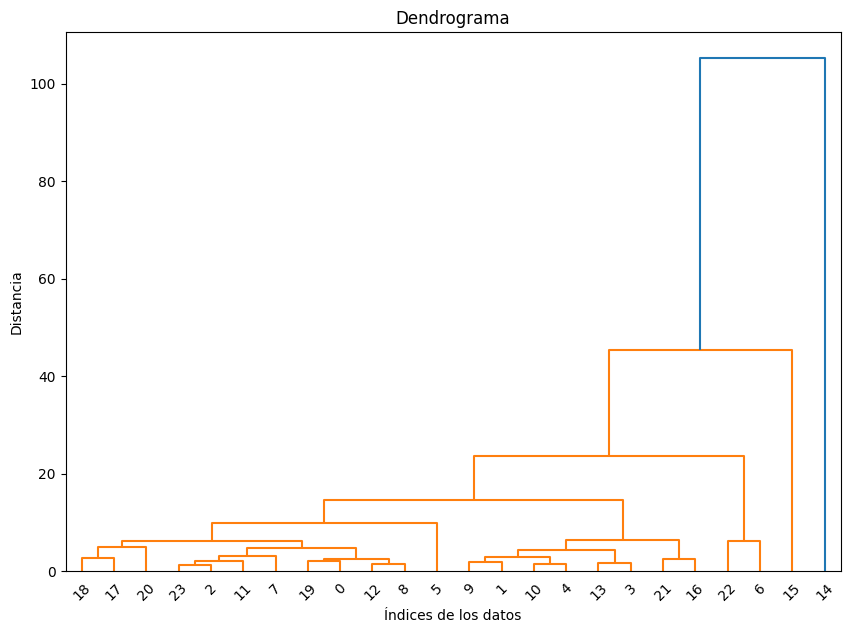

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Usando el mismo dataset
data = df[['GDP (USD Billion)', 'Population (Millions)', 'Unemployment Rate (%)', 'Average Age', 'Women (%)', 'Men (%)', 'Budget (USD Billion)']].values

# Calcular las distancias entre los puntos
distances = pdist(data)

# Aplicar clustering jerárquico con el método de enlace completo (distancia máxima)
linked = linkage(distances, method='complete')

# Crear el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)

plt.title("Dendrograma")
plt.xlabel("Índices de los datos")
plt.ylabel("Distancia")
plt.show()

# Punto 2. PCA con GDP (USD Billion) y Population (Millions)

2.1. Matriz de Covarianza:
 [[396.58465517  26.68522414]
 [ 26.68522414   1.83015414]]
2.2. Eigenvalues (Valores propios):
 [3.44139937e-02 3.98380395e+02]
2.3. Varianza explicada por cada eigenvalue:
 [8.63772954e-05 9.99913623e-01]
2.4. Eigenvector (Vector propio) correspondiente al mayor eigenvalue:
 [-0.99774346 -0.06714158]
2.5. Matriz proyectada (Datos reducidos a 1D):
 [-94.96918871 -35.39370461 -13.71984343  -8.06533849  -1.76612638
   1.45686639   2.56109835   3.63981652   3.95458212   4.7534483
   4.95903973   5.25366286   5.55634298   5.75320601   5.95409753
   6.26147756   6.46236908   6.66393202   6.76504919   6.96661213
   7.06974356   7.26794942   7.47354085   7.57667228   7.67174671
   7.77823522   7.87599531   7.97845532   8.08024392   8.18001826]
2.6. Error entre la matriz proyectada y la original:
 [[-4.88678659e-03  7.26190790e-02]
 [ 3.61627519e-02 -5.37389078e-01]
 [-3.88840323e-02  5.77828101e-01]
 [ 2.86128484e-03 -4.25195301e-02]
 [-1.21410457e-02  1.80419493e-

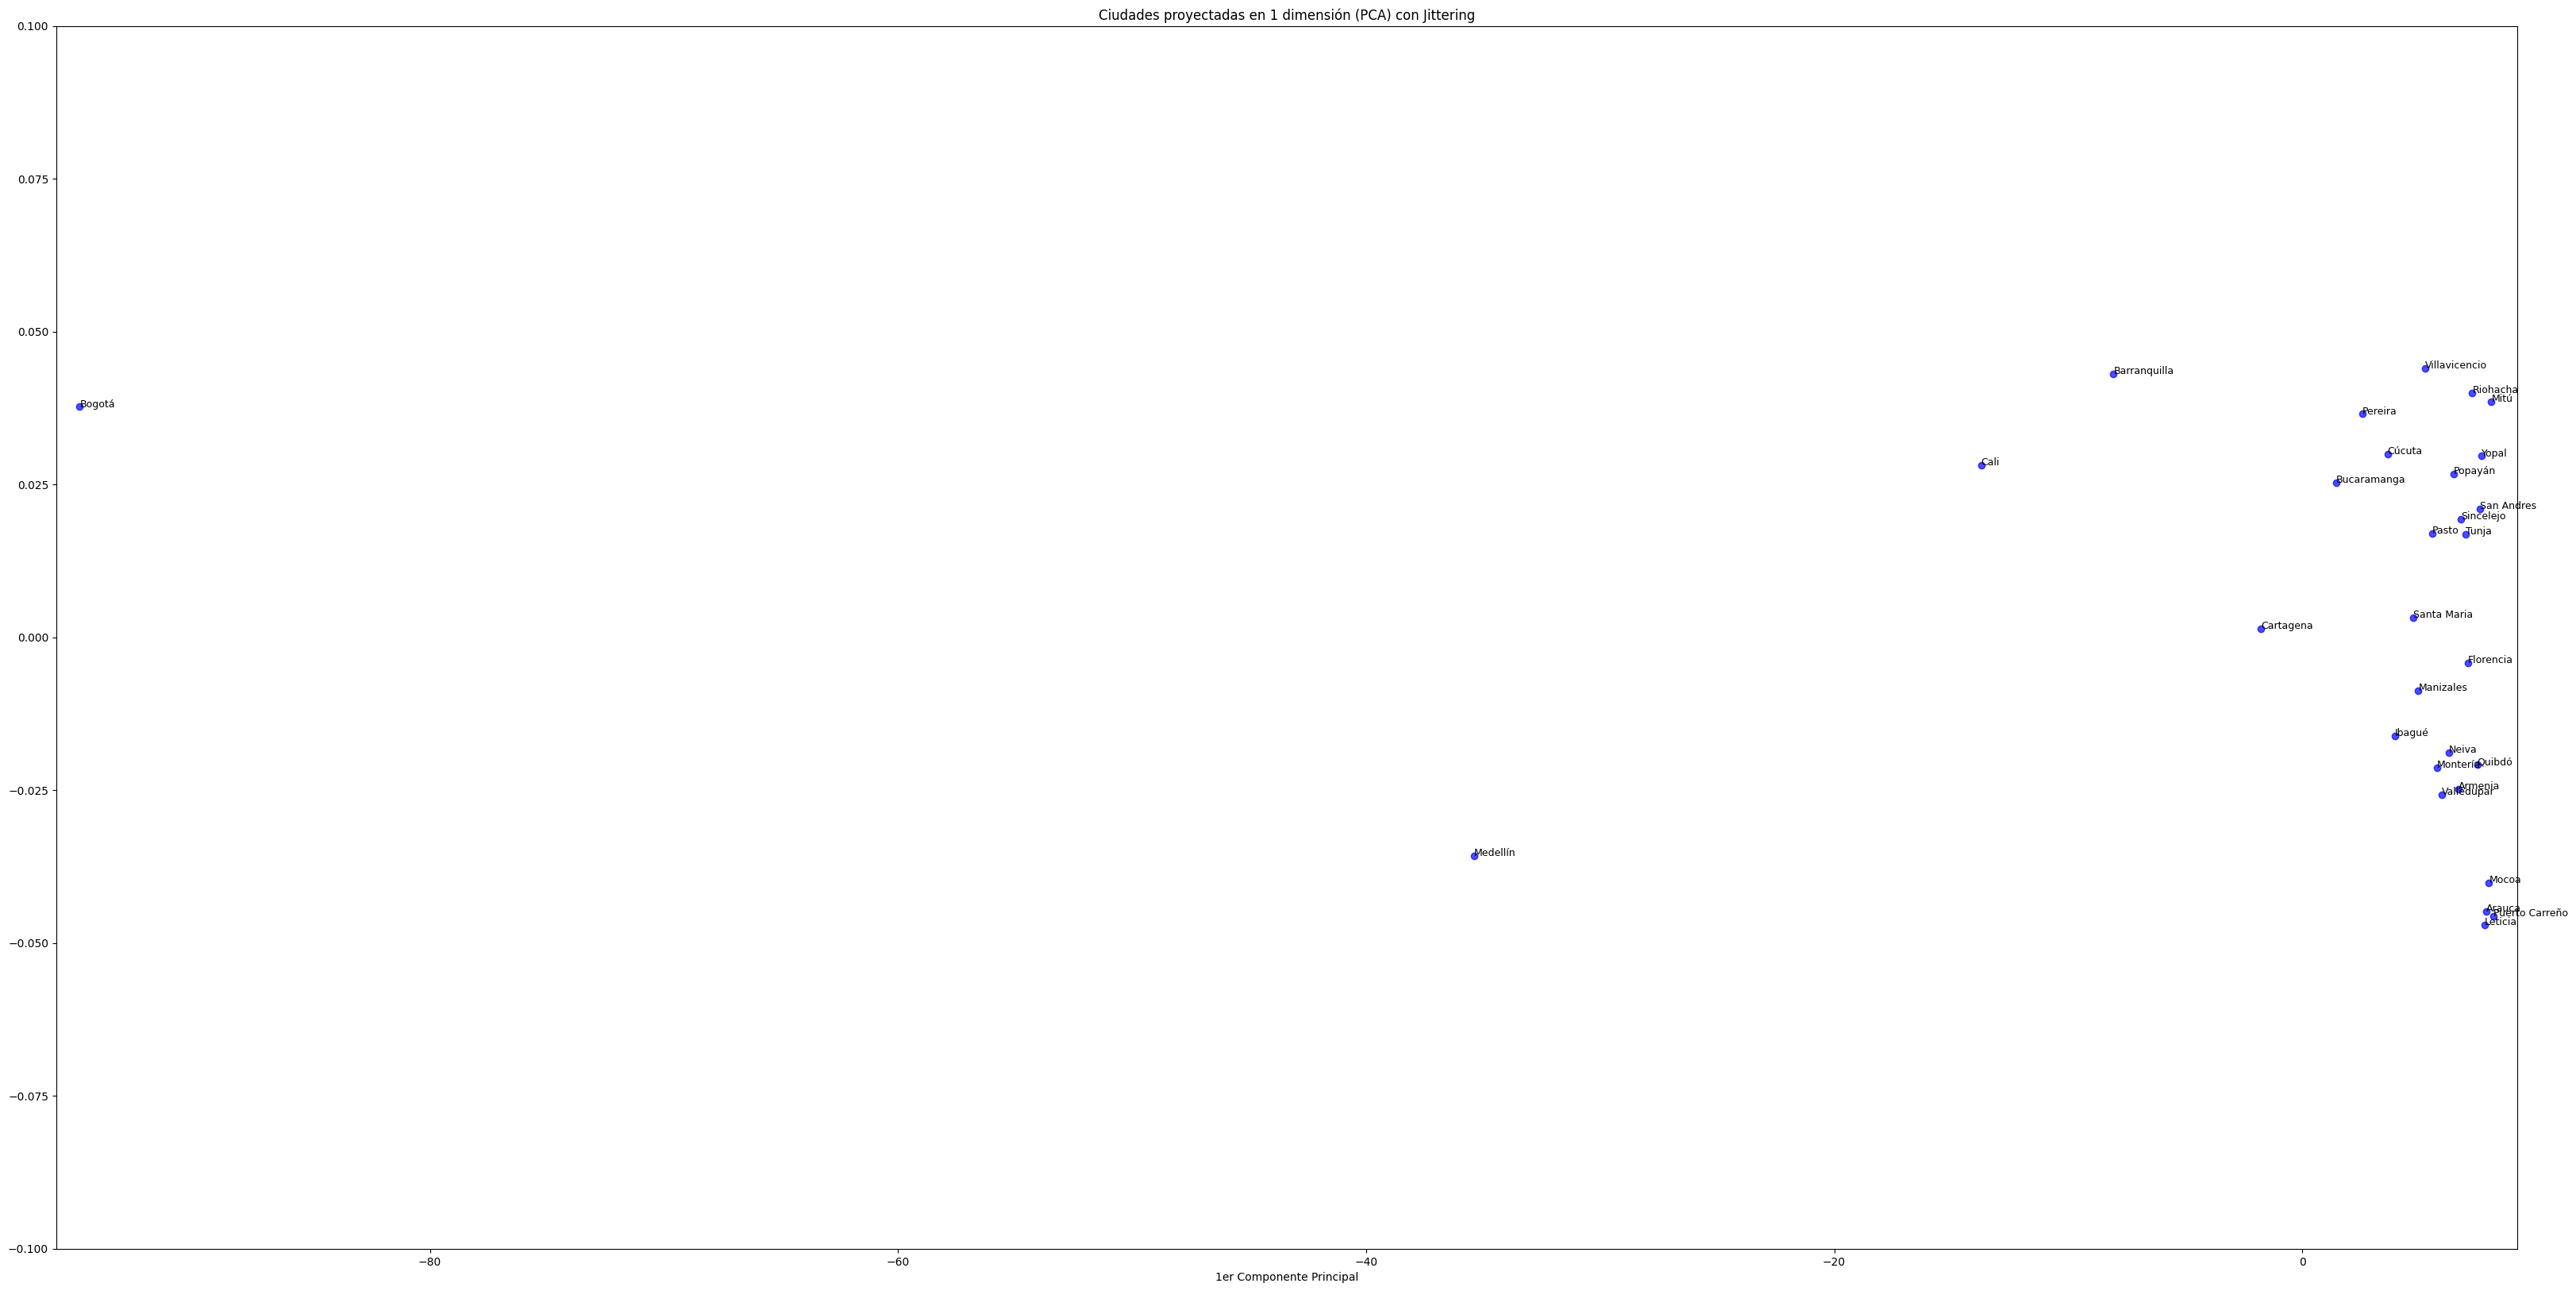

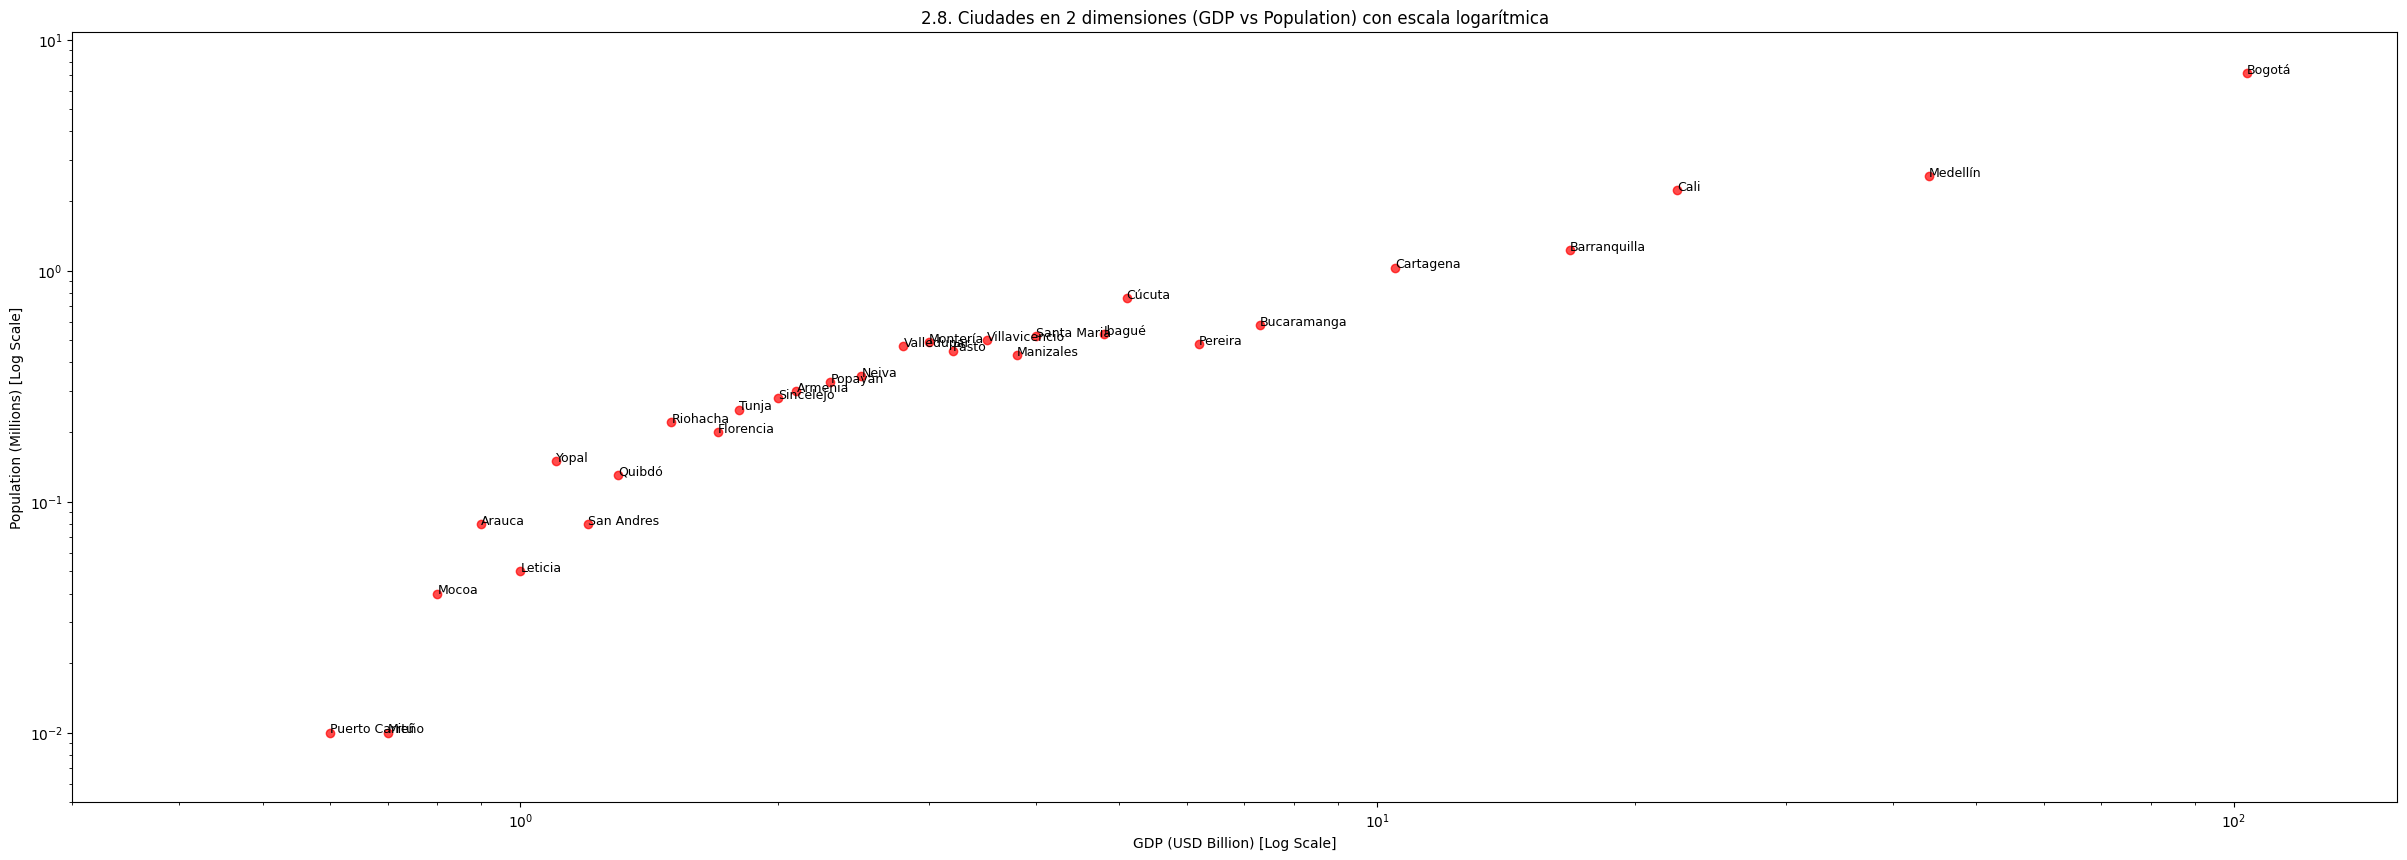

In [32]:
# Definición de los datos
dataByPca = {
    'city': ['Bogotá', 'Medellín', 'Cali', 'Barranquilla', 'Cartagena', 'Bucaramanga', 'Pereira', 'Cúcuta', 'Ibagué',
             'Santa Maria', 'Manizales', 'Villavicencio', 'Pasto', 'Montería', 'Valledupar', 'Neiva', 'Popayán', 
             'Armenia', 'Sincelejo', 'Tunja', 'Florencia', 'Riohacha', 'Quibdó', 'San Andres', 'Yopal', 'Leticia', 
             'Arauca', 'Mocoa', 'Mitú', 'Puerto Carreño'],
    'gdpUsdBillion': [103.5, 44.1, 22.4, 16.8, 10.5, 7.3, 6.2, 5.1, 4.8, 4.0, 3.8, 3.5, 3.2, 3.0, 2.8, 2.5, 2.3, 
                      2.1, 2.0, 1.8, 1.7, 1.5, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6],
    'populationMillions': [7.18, 2.57, 2.23, 1.23, 1.03, 0.58, 0.48, 0.76, 0.53, 0.52, 0.43, 0.50, 0.45, 0.49, 0.47, 
                           0.35, 0.33, 0.30, 0.28, 0.25, 0.20, 0.22, 0.13, 0.08, 0.15, 0.05, 0.08, 0.04, 0.01, 0.01]
}

# Crear DataFrame
dfPca = pd.DataFrame(dataByPca)

# Extraer variables para PCA
X = dfPca[['gdpUsdBillion', 'populationMillions']].values

# Centrar los datos restando la media
XCentered = X - np.mean(X, axis=0)

# 2.1. Matriz de Covarianza
covMatrix = np.cov(XCentered, rowvar=False)
print("2.1. Matriz de Covarianza:\n", covMatrix)

# 2.2. Calcular Eigenvalues y Eigenvectors
eigenValues, eigenVectors = np.linalg.eigh(covMatrix)
print("2.2. Eigenvalues (Valores propios):\n", eigenValues)

# 2.3. Calcular la varianza explicada por cada Eigenvalue
explainedVariance = eigenValues / np.sum(eigenValues)
print("2.3. Varianza explicada por cada eigenvalue:\n", explainedVariance)

# 2.4. Eigenvector correspondiente al mayor Eigenvalue
principalEigenvector = eigenVectors[:, np.argmax(eigenValues)]
print("2.4. Eigenvector (Vector propio) correspondiente al mayor eigenvalue:\n", principalEigenvector)

# 2.5. Proyectar los datos a 1 dimensión utilizando el primer Eigenvector
XProjected = np.dot(XCentered, principalEigenvector)
print("2.5. Matriz proyectada (Datos reducidos a 1D):\n", XProjected)

# 2.6. Error entre la matriz proyectada y la original
XReconstructed = np.outer(XProjected, principalEigenvector) + np.mean(X, axis=0)
error = X - XReconstructed
print("2.6. Error entre la matriz proyectada y la original:\n", error)
print("Error medio por columna:\n", np.mean(np.abs(error), axis=0))

# 2.7. Graficar las ciudades proyectadas en 1 dimensión con Jittering
jitter = np.random.uniform(-0.05, 0.05, size=XProjected.shape)  # Pequeño desplazamiento vertical aleatorio
plt.figure(figsize=(40, 20))
plt.scatter(XProjected, jitter, alpha=0.7, color='blue')

citysPca = dfPca['city']
# Agregar etiquetas a los puntos con jitter
for i, city in enumerate(citysPca):
    plt.text(XProjected[i], jitter[i], city, fontsize=9)

# Ajustar límites para ampliar la separación entre los puntos
plt.xlim(XProjected.min() - 1, XProjected.max() + 1)
plt.ylim(-0.1, 0.1)  # Limitar el eje Y para que los puntos queden alineados, pero con jitter
plt.title('Ciudades proyectadas en 1 dimensión (PCA) con Jittering')
plt.xlabel('1er Componente Principal')
plt.show()

# 2.8. Graficar las ciudades en las 2 dimensiones originales con escala logarítmica y ajustes en los límites
plt.figure(figsize=(30,10))
# Aplicar escala logarítmica en ambos ejes
plt.xscale('log')
plt.yscale('log')

# Graficar los puntos
plt.scatter(X[:, 0], X[:, 1], alpha=0.7, color='red')

# Añadir etiquetas a las ciudades
for i, city in enumerate(citysPca):
    plt.text(X[i, 0], X[i, 1], city, fontsize=9)
    
plt.title('2.8. Ciudades en 2 dimensiones (GDP vs Population) con escala logarítmica')
plt.xlabel('GDP (USD Billion) [Log Scale]')
plt.ylabel('Population (Millions) [Log Scale]')

# Ajustar límites manualmente si es necesario
plt.xlim(X[:, 0].min() * 0.5, X[:, 0].max() * 1.5)
plt.ylim(X[:, 1].min() * 0.5, X[:, 1].max() * 1.5)
plt.show()

# Punto 3. PCA para datos de entrenamiento sobre rostros
## Empezamos descargando los archivos para entrenar el modelo

In [40]:
import os
from os.path import isfile
from urllib.request import urlretrieve
import zipfile

def downloadFiles():
    """
    Este metodo descarga los archivos de imagenes sino existen
    """
    path_tar = os.path.join("data", 'faces.zip')
    # Verificar si el archivo ZIP ya existe
    if not isfile(path_tar):
        urlretrieve(
            'http://courses.media.mit.edu/2002fall/mas622j/proj/faces/rawdata.zip',
            path_tar)
    
    dest_path = "data/faces"
    # Abrir y extraer el archivo ZIP
    with zipfile.ZipFile(path_tar, 'r') as zip_ref:
        zip_ref.extractall(dest_path)

downloadFiles()

## Pasamos a realizar el PCA con los datos de entrenamiento ubicados en data
### Primero Cargamos los datos de entrenamiento

In [73]:
# Paso 1: Cargar las imágenes de entrenamiento según el archivo CSV
def loadImagesFromCsv(folder, csvFile):
    with open(csvFile, 'r') as f:
        trainImages = f.read().strip().split(',')
        # Eliminar espacios adicionales alrededor de los nombres
        trainImages = [imgName.strip() for imgName in trainImages]
    X = []
    for nfile in os.listdir(folder):
        if nfile in trainImages:  # Solo cargar imágenes que estén en la lista del CSV
            with open(os.path.join(folder, nfile), "rb") as f:
                bytesRead = f.read()
                img = Image.frombytes('L', (128, 128), bytesRead)
                X.append(np.array(img).flatten())  # Convertir a array 1D
    return np.array(X)

# Paso 2: Mostrar imágenes
def plotOneImage(data, label="Image 1", ax=None):
    fnShape = lambda X: X.reshape(128, 128)
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)
    ax.imshow(fnShape(data), cmap='gray')
    ax.set_title(label=label)
    return fig, ax

def plotThreeImages(data, ix1, ix2, ix3):
    fnShape = lambda X: X.reshape(128, 128)
    fig, ax = plt.subplots(1, 3, constrained_layout=True)
    ax[0].imshow(fnShape(data[ix1]), cmap='gray')
    ax[0].set_title(f"Image {ix1}")
    ax[1].imshow(fnShape(data[ix2]), cmap='gray')
    ax[1].set_title(f"Image {ix2}")
    ax[2].imshow(fnShape(data[ix3]), cmap='gray')
    ax[2].set_title(f"Image {ix3}")
    plt.show()

dName = 'data/faces/rawdata'  # Directorio de las imágenes
csvFile = 'data/pca-faces/train-pca.csv'  # Archivo CSV con los nombres de las imágenes de entrenamiento

X = loadImagesFromCsv(dName, csvFile)
print("Imagenes cargadas satisfactoriamente")

Imagenes cargadas satisfactoriamente


# Despues creamos los métodos para mostrar las imagenes, mostrar la 'Mean Face' y mostrar el número de componentes para una varianza del 99%

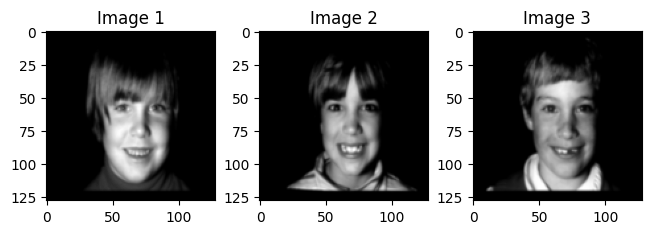



Número de componentes para 99% varianza: 162




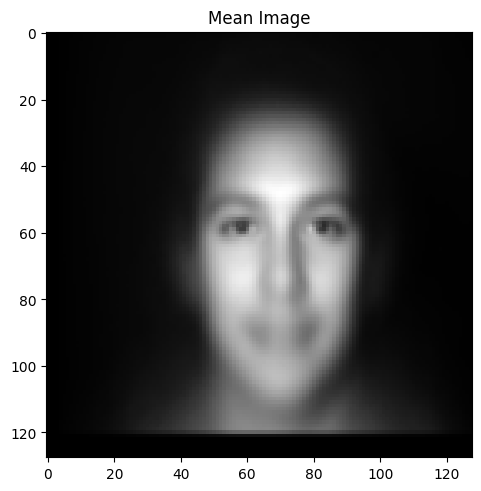

In [74]:
from sklearn.decomposition import PCA

# Mostrar algunas imágenes
plotThreeImages(X, 1, 2, 3)
# Calcular la cara media
XMean = X.mean(axis=0)
plotOneImage(XMean, label="Mean Image")

# Centrar las imágenes
XCenter = X - XMean

# Aplicar PCA (manteniendo n_components alto para explicar el 99% de la varianza)
pca = PCA(n_components=200)
XReduced = pca.fit_transform(XCenter)
eigenValues = pca.explained_variance_
eigenFaces = pca.components_

# Calcular el número de componentes necesarios para el 99% de la varianza
listaEigenValues99 = []
for eigenValue in eigenValues:
    listaEigenValues99.append(eigenValue)
    porcentaje = sum(listaEigenValues99) / sum(eigenValues)
    if porcentaje >= 0.99:
        break

print(f"\n\nNúmero de componentes para 99% varianza: {len(listaEigenValues99)}\n\n")

### 5 primeras caras con los componentes solicitados en el punto 2 (1, 3, 20, 85 y 99 respectivamente)

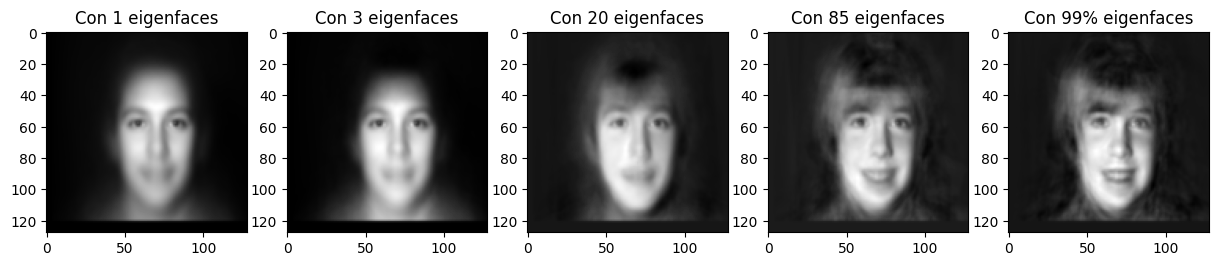

In [75]:
# Reconstruir imágenes con diferentes números de componentes
face1 = XMean + np.sum(np.dot(XReduced[1].reshape(1, -1)[:, :1], eigenFaces[:1, :]), axis=0)
face3 = XMean + np.sum(np.dot(XReduced[1].reshape(1, -1)[:, :3], eigenFaces[:3, :]), axis=0)
face20 = XMean + np.sum(np.dot(XReduced[1].reshape(1, -1)[:, :20], eigenFaces[:20, :]), axis=0)
face85 = XMean + np.sum(np.dot(XReduced[1].reshape(1, -1)[:, :85], eigenFaces[:85, :]), axis=0)
face161 = XMean + np.sum(np.dot(XReduced[1].reshape(1, -1)[:, :161], eigenFaces[:161, :]), axis=0)

fig, ax = plt.subplots(1, 5, figsize=(15, 15))
plotOneImage(face1, ax=ax[0], label="Con 1 eigenfaces")
plotOneImage(face3, ax=ax[1], label="Con 3 eigenfaces")
plotOneImage(face20, ax=ax[2], label="Con 20 eigenfaces")
plotOneImage(face85, ax=ax[3], label="Con 85 eigenfaces")
plotOneImage(face161, ax=ax[4], label="Con 99% eigenfaces")
plt.show()

### Validación con los datos de prueba

In [91]:
from sklearn.metrics import mean_squared_error

# Función para cargar las imágenes desde un archivo CSV
def loadImagesTestFromCsv(folder, csvFile):
    with open(csvFile, 'r') as f:
        imageNames = f.read().strip().replace('\n', '').replace('"', '').split(',')
        # Eliminar espacios adicionales y espacios dentro de los nombres
        imageNames = [imgName.replace(' ', '').strip() for imgName in imageNames]
    X = []
    for nfile in os.listdir(folder):
        if nfile in imageNames:
            with open(os.path.join(folder, nfile), "rb") as f:
                bytesRead = f.read()
                img = Image.frombytes('L', (128, 128), bytesRead)
                X.append(np.array(img).flatten())  # Convertir a array 1D
    return np.array(X), imageNames


# Función para centrar imágenes
def centerImages(images, meanFace):
    return images - meanFace

# Función para proyectar las imágenes en el espacio PCA
def projectImagesPca(images, eigenFaces):
    return np.dot(images, eigenFaces.T)

# Cargar y procesar las imágenes de prueba
csvFileTest = 'data/pca-faces/test-pca.csv'  # Archivo CSV de prueba
XTest, testImageNames = loadImagesTestFromCsv(dName, csvFileTest)

# Centrar las imágenes de prueba utilizando la cara media calculada durante el entrenamiento
XTestCenter = centerImages(XTest, XMean)

# Proyectar los datos de prueba en el espacio PCA utilizando las componentes del PCA entrenado
XTestReduced = projectImagesPca(XTestCenter, eigenFaces)

# Extraer el primer componente para cada imagen de prueba
firstComponent = XTestReduced[:, 0]
# Crear un DataFrame con los resultados
dfSubmission = pd.DataFrame({
    'id': testImageNames,
    'label': firstComponent
})

# Guardar el archivo de envío en formato CSV
df_submission.to_csv('submission.csv', index=False)

print("Archivo de envío 'submission' creado con éxito.")

Longitud de testImageNames: 300
Longitud de firstComponent: 300
Archivo de envío 'submission' creado con éxito.


## Conclusiones

### 1 eigenface: La imagen captura solo la estructura básica de la cara, resaltando las características más prominentes (como la forma de la cabeza o el contorno del rostro), pero falta casi todo el detalle fino.
### 3 eigenfaces: La imagen añade algunos detalles, pero aún se ve borrosa. Se mejoran rasgos generales como los ojos, la nariz y la boca, aunque aún no son claros.
### 20 eigenfaces: Aparecen más detalles específicos. El rostro es claramente visible, y los rasgos faciales se distinguen con mayor claridad. Aunque faltan algunos detalles sutiles, la imagen es bastante precisa.
### 85 eigenfaces: La imagen es casi idéntica a la original. Los detalles más finos, como las arrugas y las sombras, se vuelven visibles.
### 161 eigenfaces (99%): La imagen es casi idéntica a la original. Se ha retenido casi toda la varianza.

### A medida que se añaden más eigenfaces, se capturan detalles adicionales de la cara, pasando de una representación borrosa y simplificada a una imagen con todos los detalles originales. Esto se debe a que los primeros componentes principales (eigenfaces) contienen la mayor parte de la varianza (información relevante) del conjunto de datos. Los eigenfaces iniciales capturan patrones generales, mientras que los componentes adicionales agregan detalles más finos, como texturas o características pequeñas del rostro.

# Punto 4. Análisis Dataset Amazon_product.csv

## Primero Cargamos los datos del dataset

In [26]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from scipy import stats

dfAmazonProduct = pd.read_csv('data/amazon-product/amazon_product.csv')
print("Datos cargados satisfactoriamente")

Datos cargados satisfactoriamente
Index(['Unnamed: 0', 'asin', 'product_title', 'product_price',
       'product_original_price', 'currency', 'product_star_rating',
       'product_num_ratings', 'product_url', 'product_photo',
       'product_num_offers', 'product_minimum_offer_price', 'is_best_seller',
       'is_amazon_choice', 'is_prime', 'climate_pledge_friendly',
       'sales_volume', 'delivery', 'has_variations', 'product_availability',
       'unit_price', 'unit_count'],
      dtype='object')
   Unnamed: 0        asin                                      product_title  \
0           0  B0BQ118F2T  Moto G Play 2023 3-Day Battery Unlocked Made f...   
1           1  B0CTD47P22  SAMSUNG Galaxy A15 5G (SM-156M/DSN), 128GB 6GB...   
2           2  B0CHH6X6H2  Total by Verizon | Samsung Galaxy A03s | Locke...   
3           3  B0BZ9XNBRB  Google Pixel 7a - Unlocked Android Cell Phone ...   
4           4  B0CN1QSH8Q  SAMSUNG Galaxy A15 5G A Series Cell Phone, 128...   

  product_pri

## Formatear e imputar datos necesarios del dataset

In [54]:
from sklearn.impute import SimpleImputer

# Convertir 'sales_volume' a numérico
dfAmazonProduct['salesVolumeNumeric'] = dfAmazonProduct['sales_volume'].str.extract(r'(\d+K)')[0].str.replace('K', '000').astype(float)

# Limpiar columnas de precios, quitando símbolos y convirtiendo a float
dfAmazonProduct['product_price'] = dfAmazonProduct['product_price'].replace({'\\$':'', ',':''}, regex=True).astype(float)
dfAmazonProduct['product_original_price'] = dfAmazonProduct['product_original_price'].replace({'\\$':'', ',':''}, regex=True).astype(float)
dfAmazonProduct['product_num_ratings'] = pd.to_numeric(dfAmazonProduct['product_num_ratings'], errors='coerce')
dfAmazonProduct['product_num_offers'] = pd.to_numeric(dfAmazonProduct['product_num_offers'], errors='coerce')
dfAmazonProduct['product_minimum_offer_price'] = pd.to_numeric(dfAmazonProduct['product_minimum_offer_price'].replace({'\\$':'', ',':''}, regex=True), errors='coerce')
# Imputación usando la interpolación lineal (sólo para datos numéricos y secuenciales)
dfAmazonProduct['productPriceClean'] = dfAmazonProduct['productPriceClean'].interpolate()

# Usar el SimpleImputer de scikit-learn para imputación basada en la media
imputer = SimpleImputer(strategy='mean')
dfAmazonProduct[['productPriceClean', 'product_original_price']] = imputer.fit_transform(dfAmazonProduct[['product_price', 'product_original_price']])

print("Datos formateados correctamente")

Datos formateados correctamente


## 4.1.1 Gráfico de barras para variables categóricas

In [56]:
categoricalColumns = ['currency', 'is_best_seller', 'is_amazon_choice', 'is_prime', 'climate_pledge_friendly', 'delivery', 'has_variations']

dfAmazonProduct[categoricalColumns] = dfAmazonProduct[categoricalColumns].fillna('')

for col in categoricalColumns:
    fig = px.bar(dfAmazonProduct, x=col, title=f'Distribución de {col}', labels={col: 'Categoría', 'count': 'Número de observaciones'})
    fig.show()

# 4.1.2 Histograma para variables numéricas y detección de outliers

In [31]:
import numpy as np
numericalColumns = ['productPriceClean', 'productOriginalPriceClean', 'product_star_rating', 'product_num_ratings', 'salesVolumeNumeric']

for col in numericalColumns:
    fig = px.histogram(dfAmazonProduct, x=col, title=f'Histograma de {col}')
    fig.show()

    # Detección de outliers (mayor a 5 desviaciones estándar)
    col_data = dfAmazonProduct[col].dropna()
    zScores = np.abs(stats.zscore(col_data))
    
    # Crear una máscara booleana para identificar outliers
    outlier_mask = zScores > 5
    
    # Aplicar la máscara booleana al DataFrame original usando el índice
    outliers = dfAmazonProduct.loc[col_data.index[outlier_mask]]
    
    print(f"Outliers en {col}:")
    print(outliers[[col, 'product_title']])

Outliers en productPriceClean:
Empty DataFrame
Columns: [productPriceClean, product_title]
Index: []


Outliers en productOriginalPriceClean:
    productOriginalPriceClean  \
13                      699.0   

                                        product_title  
13  Google Pixel 8 - Unlocked Android Smartphone w...  


Outliers en product_star_rating:
Empty DataFrame
Columns: [product_star_rating, product_title]
Index: []


Outliers en product_num_ratings:
    product_num_ratings product_title
55              1015448       Disney+


Outliers en salesVolumeNumeric:
Empty DataFrame
Columns: [salesVolumeNumeric, product_title]
Index: []


# 4.2.1 Boxplot para variables categóricas vs salesVolume

In [32]:
for col in categoricalColumns:
    fig = px.box(dfAmazonProduct, x=col, y='salesVolumeNumeric', title=f'Relación entre {col} y ventas')
    fig.show()

# 4.2.2 Scatter plot para variables numéricas vs salesVolume

In [33]:
for col in numericalColumns:
    fig = px.scatter(dfAmazonProduct, x=col, y='salesVolumeNumeric', title=f'Relación entre {col} y ventas')
    fig.show()

# 4.3.1 Matriz de correlación para variables numéricas

In [36]:
correlationMatrix = dfAmazonProduct[['productPriceClean', 'productOriginalPriceClean', 'product_star_rating', 'product_num_ratings', 'salesVolumeNumeric']].corr()

fig = go.Figure(data=go.Heatmap(
        z=correlationMatrix.values,
        x=correlationMatrix.columns,
        y=correlationMatrix.columns,
        colorscale='Viridis'))
fig.update_layout(title='Matriz de correlación')
fig.show()

print(f"Correlación entre variables y salesVolumeNumeric: {correlationMatrix['salesVolumeNumeric'].sort_values(ascending=False)}\n")

Correlación entre variables y salesVolumeNumeric: salesVolumeNumeric           1.000000
product_star_rating          0.311876
product_num_ratings          0.279334
productOriginalPriceClean   -0.266958
productPriceClean           -0.341847
Name: salesVolumeNumeric, dtype: float64



## 4.3.2 Crear variables dummy y recalcular la matriz de correlación

In [73]:
import plotly.graph_objects as go

dfWithDummiesCategorical = pd.get_dummies(dfAmazonProduct[categoricalColumns])

dfDummies = pd.concat([dfAmazonProduct[['product_price', 'product_original_price', 'product_num_ratings', 
                                 'product_num_offers', 'product_minimum_offer_price', 'salesVolumeNumeric']], 
                            dfWithDummiesCategorical], axis=1)

# Matriz de correlación con dummies
correlationMatrixWithDummies = dfDummies.corr()

# Crear un mapa de calor de la matriz de correlación
fig = go.Figure(data=go.Heatmap(
    z=correlationMatrixWithDummies.values,
    x=correlationMatrixWithDummies.columns,
    y=correlationMatrixWithDummies.columns,
    colorscale='Viridis'))

fig.update_layout(title='Matriz de correlación con variables dummies')
fig.show()
# Ver la variable categórica con mayor correlación
print("Correlación de variables categóricas con salesVolumeNumeric: ")
sortedCorrelation = correlationMatrixWithDummies['salesVolumeNumeric'].sort_values(ascending=False)
print(sortedCorrelation)
print(f'\nVariable con mayor correlación: {sortedCorrelation.index[1]}')

Correlación de variables categóricas con salesVolumeNumeric: 
salesVolumeNumeric                                                                                                                                        1.000000
is_best_seller                                                                                                                                            0.610724
delivery_FREE delivery                                                                                                                                    0.489391
delivery_FREE delivery Tue, Aug 6 on $35 of items shipped by Amazon                                                                                       0.386527
product_num_ratings                                                                                                                                       0.279334
delivery_FREE delivery Thu, Aug 8 on $35 of items shipped by Amazon                                                        

## Resultados Clave:
## Variables con Correlación Positiva Alta:

is_best_seller (0.6107): Hay una correlación positiva alta con salesVolumeNumeric, lo que indica que los productos que son considerados "best sellers" tienden a tener un mayor volumen de ventas. Esto es esperado, ya que los best sellers generalmente tienen un alto volumen de ventas.
delivery_FREE delivery (0.4894): También tiene una correlación positiva alta, sugiriendo que los productos con entrega gratuita tienen mayores volúmenes de ventas.
Variables con Correlación Negativa Alta:

product_price (-0.3418): La correlación negativa indica que a medida que aumenta el precio del producto, el volumen de ventas tiende a disminuir. Esto puede ser una tendencia general en la que productos más caros tienen menos ventas.
product_minimum_offer_price (-0.3256): Similar al precio del producto, un mayor precio mínimo de oferta está asociado con un menor volumen de ventas.
is_prime (-0.3125): Aunque es menos pronunciado, los productos que no tienen la etiqueta de Prime tienden a tener un menor volumen de ventas, posiblemente porque los miembros Prime pueden preferir productos con entrega rápida.

## Explicación de Coeficientes Positivos y Negativos:
Coeficientes Positivos: Un coeficiente positivo indica que, a medida que aumenta el valor de la variable, también lo hace el volumen de ventas. Esto podría ser el caso para variables como is_best_seller o delivery_FREE delivery, donde características como la popularidad o la oferta de envío gratuito están asociadas con un mayor volumen de ventas.

Coeficientes Negativos: Un coeficiente negativo indica que, a medida que aumenta el valor de la variable, el volumen de ventas disminuye. Esto puede suceder con variables como product_price, donde un precio más alto podría reducir el volumen de ventas debido a la sensibilidad al precio de los consumidores.

## 4.3.2. Matriz de Correlación con Variables Dummy
## Resultados Clave:
Variable con Mayor Correlación con salesVolumeNumeric:
La variable categórica con la mayor correlación positiva es delivery_FREE delivery (0.4894). Esto indica que la oferta de entrega gratuita está altamente asociada con un mayor volumen de ventas.
Explicación:
La variable delivery_FREE delivery tiene una correlación significativa con salesVolumeNumeric, lo que sugiere que los productos con entrega gratuita tienden a tener un mayor volumen de ventas.